In [38]:

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

#warnings.filterwarnings(action='once')
import pandas as pd
from pandas import MultiIndex, Int16Dtype
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.pyplot as pyplot
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, f1_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, PredefinedSplit
# models
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn import ensemble
from sklearn import datasets
from sklearn import model_selection

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [23]:
#!pip3 install xgboost --upgrade

In [24]:
df_train = pd.read_csv('../data/train_encoded_1.csv')
df_test = pd.read_csv('../data/test_encoded_1.csv')
df_test = df_test.reindex(columns=df_train.columns.intersection(df_test.columns))

In [25]:
from sklearn.model_selection import train_test_split
np.random.seed(0)

train, valid = train_test_split(df_train, test_size=0.2)

In [26]:
X_full = df_train.drop(['price', 'price_per_sqft'], axis=1)
y_full = df_train['price_per_sqft']
X_train = train.drop(['price', 'price_per_sqft'], axis=1)
y_train = train['price_per_sqft']

X_valid = valid.drop(['price', 'price_per_sqft'], axis=1)
y_valid = valid['price_per_sqft']

df_test_size_sqft = df_test['size_sqft'].copy()
#df_test= df_test.drop(['size_sqft'], axis=1)

idxs = np.arange(X_train.shape[0])
np.random.shuffle(idxs)
df_test.columns.difference(X_train.columns)


Index([], dtype='object')

In [27]:
X_train.columns.difference(df_test.columns)


Index([], dtype='object')

In [28]:
model = ExtraTreesRegressor()
model.fit(X_train, y_train)

yt_pred = model.predict(X_train)
yv_pred = model.predict(X_valid)

print('Training RMSE: {:.3f}'.format(mean_squared_error(yt_pred, y_train, squared=False)))
print('Test RMSE: {:.3f}'.format(mean_squared_error(yv_pred, y_valid, squared=False)))


Training RMSE: 72.420
Test RMSE: 234.491


In [29]:
yTest = model.predict(df_test)

yTest = yTest * df_test_size_sqft
yTest = pd.DataFrame(yTest.values, columns=['Predicted'], index=df_test.index)

yTest.to_csv('../predictions/extra_trees_plain.csv')

In [30]:
model.fit(X_full, y_full)

yt_pred = model.predict(X_full)

print('Training RMSE: {:.3f}'.format(mean_squared_error(yt_pred, y_full, squared=False)))

yTest = model.predict(df_test)

yTest = yTest * df_test_size_sqft
yTest = pd.DataFrame(yTest.values, columns=['Predicted'], index=df_test.index)

yTest.to_csv('../predictions/extra_trees_plain_full.csv')

Training RMSE: 79.073


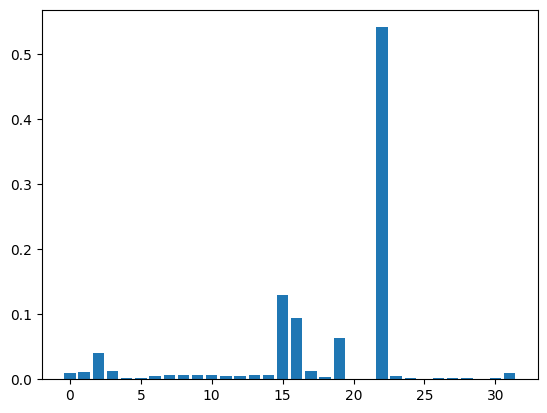

In [34]:
model.feature_importances_
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

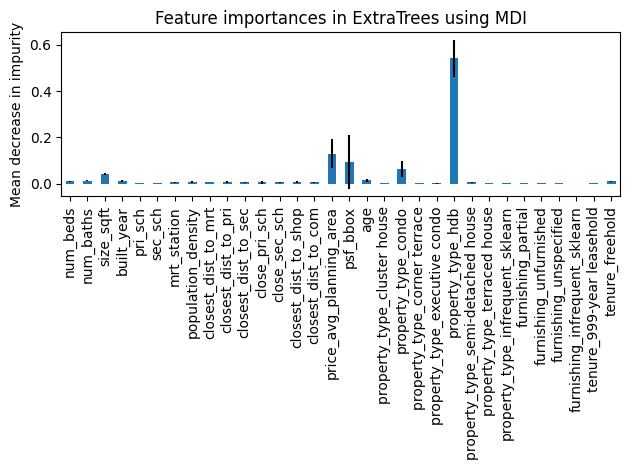

In [54]:
feature_names = X_train.columns
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances in ExtraTrees using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


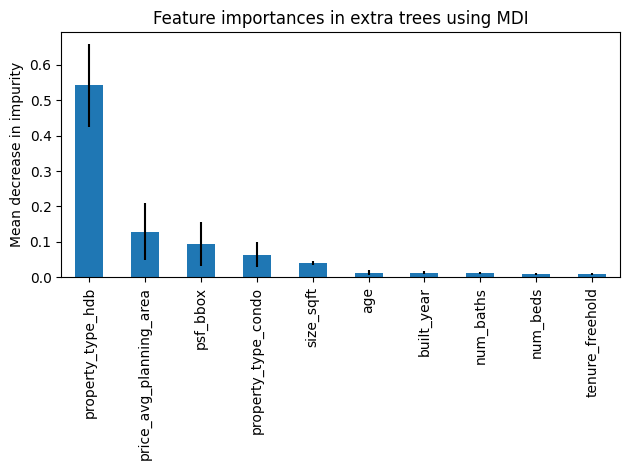

In [55]:
feature_names = X_train.columns
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
fig, ax = plt.subplots()
std_top_ten = np.sort(std)[::-1][:10]
forest_importances = pd.Series(importances, index=feature_names)
forest_importances_top_ten = forest_importances.sort_values(ascending = False)[:10]
forest_importances_top_ten.plot.bar(yerr=std_top_ten, ax=ax)
ax.set_title("Feature importances in extra trees using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [16]:
model.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [17]:
warnings.filterwarnings('ignore')

model = ExtraTreesRegressor()

parameters = {'n_estimators':[10,100,1000],
              'min_samples_split':[2],
              'min_samples_leaf':[1],
              'min_weight_fraction_leaf':[0.0],
              'max_features':['sqrt', 'log2', 1.0, 'auto'],
              'bootstrap': [True, False],
              'oob_score':[False, True],
              'n_jobs':[-1],
              'warm_start':[True],
              'random_state' :[42]}

clf = GridSearchCV(model, parameters, n_jobs=5, 
                   cv=KFold(n_splits=2, shuffle=True, random_state=42), 
                   scoring='neg_root_mean_squared_error',
                refit=True)

clf.fit(X_train, y_train)

yt_pred = clf.predict(X_train)
yv_pred = clf.predict(X_valid)

print('Training RMSE: {:.3f}'.format(mean_squared_error(yt_pred, y_train, squared=False)))
print('Test RMSE: {:.3f}'.format(mean_squared_error(yv_pred, y_valid, squared=False)))


/usr/local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr

Training RMSE: 105.484
Test RMSE: 231.187


In [18]:
print(clf.best_params_)

print(clf.best_estimator_)

print(clf.best_score_)

print(clf.predict(df_test.copy()))


{'bootstrap': True, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'warm_start': True}
ExtraTreesRegressor(bootstrap=True, max_features=1.0, n_estimators=1000,
                    n_jobs=-1, random_state=42, warm_start=True)
-254.2614023646367
[2555.2515324  1415.57297789 1969.86143492 ... 3077.03650432  667.1789809
 2956.70129876]


In [19]:
yTest = clf.predict(df_test)

yTest = yTest * df_test_size_sqft
yTest = pd.DataFrame(yTest.values, columns=['Predicted'], index=df_test.index)

yTest.to_csv('../predictions/extra_trees_grid_search.csv')